# CUB-200 image segmentation using U-Net

Unsupervised learning consists in creating a new type of label to predict on data that may or may not have been labelled initially. This new type a label could be a rotation angle for instance. This allows for the creation of custom weights that can serve as a good basis for the later "real" model training.

Note that the type of label used for unsupervised learning has to be selected somewhat carefully. For instance, rotations are useful when the "real" labels are expected to have specific orientations in the images (_e.g._, planes tend to be rather horizontal in images where they are on the ground). This label would not be useful for images where such orientations do not exist (_e.g._, most cellular microscopy images).

The data used for unsupervised learning should look similar to the data of interest, but does not have to match it perfectly, as real labels do not matter for this kind of learning.

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import albumentations as A
from albumentations.pytorch import ToTensorV2

from Trainer import ModelTrainer
from CUB200 import CUB200

/Users/alexis_reymbaut/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Directory to load/save datasets and models
data_dir = './datasets/'
if (not os.path.isdir(data_dir)):
    os.mkdir(data_dir)

model_dir = './models/'
if (not os.path.isdir(model_dir)):
    os.mkdir(model_dir)

# Device
device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.backends.mps.is_available()
                      else 'cpu')

## Data preparation

In [3]:
# General image information
n_channels_in = 3  # Color images
pixel_size = 128

# Image transform
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]
train_transform = A.Compose([A.SmallestMaxSize(max_size=pixel_size),
                             A.RandomCrop(height=pixel_size, width=pixel_size),
                             A.HorizontalFlip(p=0.5),
                             A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                             A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                             A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                             A.Normalize(mean=data_mean,
                                         std=data_std),
                            ToTensorV2()], 
                            bbox_params=A.BboxParams(format='coco',
                                                     min_area=0, min_visibility=0.0, 
                                                     label_fields=['class_labels']))

transform = A.Compose([A.SmallestMaxSize(max_size=pixel_size),
                       A.CenterCrop(height=pixel_size, width=pixel_size),
                       A.Normalize(mean=data_mean,
                                   std=data_std),
                       ToTensorV2()], 
                      bbox_params=A.BboxParams(format='coco',
                                               min_area=0, min_visibility=0.0, 
                                               label_fields=['class_labels']))

# Loading dataset
dataset_path = os.path.join(data_dir, 'CUB_200/')
train_data = CUB200(dataset_path=dataset_path,
                    image_size=pixel_size,
                    transform=train_transform,
                    train_test=0,
                    return_masks=True)
test_data = CUB200(dataset_path=dataset_path,
                   image_size=pixel_size,
                   transform=transform,
                   train_test=1,
                   return_masks=True)

# Let us split the training set into train and validation sets
train_size = 0.9
n_samples_train = int(len(train_data)*train_size)
n_samples_val = len(train_data) - n_samples_train
train_data, val_data \
    = torch.utils.data.random_split(train_data,
                                    [n_samples_train, n_samples_val],
                                    generator=torch.Generator().manual_seed(42))

## Training model from scratch

We want to perform semantic (_i.e._, per-pixel) segmentation of our images, meaning that the output of our model should have the same size as the input images. This can be achieved using an autoencoder architecture, wherein:
1. the input is progressively downsampled through consecutive convolutional layers (globally called the encoder).
2. feature maps reach a certain "bottleneck" resolution.
3. feature maps are progressively upsampled back to the initial image size through consecutive transpose convolutional layers (globally called the decoder).

U-Nets are a twist on this autoencoder architecture, as skip connections are added between the encoder and decoder to allow for information to skip the bottleneck. This means that the model does not have to learn how to extract and compress the structure of the image as much as without the skip connections.

In [4]:
# Custom U-Net
class UnetDown(nn.Module):
    def __init__(self, input_size, output_size):
        super(UnetDown, self).__init__()
        
        model = [nn.BatchNorm2d(input_size),
                 nn.ELU(),
                 nn.Conv2d(input_size, output_size, kernel_size=3, stride=1, padding=1),
                 nn.BatchNorm2d(output_size),
                 nn.ELU(),
                 nn.MaxPool2d(2),
                 nn.Conv2d(output_size, output_size, kernel_size=3, stride=1, padding=1)]
        
        self.model = nn.Sequential(*model)
        
    def forward(self, x):        
        return self.model(x)
      

class UnetUp(nn.Module):
    def __init__(self, input_size, output_size):
        super(UnetUp, self).__init__()

        model = [nn.BatchNorm2d(input_size),
                 nn.ELU(),
                 nn.Conv2d(input_size, output_size, kernel_size=3, stride=1, padding=1),
                 nn.BatchNorm2d(output_size),
                 nn.ELU(),
                 nn.Upsample(scale_factor=2, mode="nearest"),  # Counterpart of the MaxPool2d
                 nn.Conv2d(output_size, output_size, kernel_size=3, stride=1, padding=1)]
          
        self.model = nn.Sequential(*model)
            
    def forward(self, x):
        return self.model(x)
            
         
class Unet(nn.Module):
    def __init__(self, channels_in, channels_out=2):
        super(Unet, self).__init__()
        
        self.conv_in = nn.Conv2d(channels_in, 64, 
                                 kernel_size=3, stride=1, padding=1)  # H x W --> H x W
        
        self.down1 = UnetDown(64, 64)  # H x W --> H/2 x W/2
        self.down2 = UnetDown(64, 128)  # H/2 x W/2 --> H/4 x W/4
        self.down3 = UnetDown(128, 128)  # H/4 x W/4 --> H/8 x W/8
        self.down4 = UnetDown(128, 256)  # H/8 x W/8 --> H/16 x W/16

        # The "*2"s below come from the skip-connection concatenations
        self.up4 = UnetUp(256, 128)  # H/16 x W/16 --> H/8 x W/8
        self.up5 = UnetUp(128*2, 128)  # H/8 x W/8 --> H/4 x W/4
        self.up6 = UnetUp(128*2, 64)  # H/4 x W/4 --> H/2 x W/2
        self.up7 = UnetUp(64*2, 64)  # H/2 x W/2 --> H x W
        
        self.conv_out = nn.Conv2d(64*2, channels_out, 
                                  kernel_size=3, stride=1, padding=1)  # H x W --> H x W

    def forward(self, x):
        x0 = self.conv_in(x)  # 64 x H x W
        
        x1 = self.down1(x0)  # 64 x H/2 x W/2
        x2 = self.down2(x1)  # 128 x H/4 x W/4
        x3 = self.down3(x2)  # 128 x H/8 x W/8
        x4 = self.down4(x3)  # 256 x H/16 x W/16

        # Bottleneck --> 256 x H/16 x W/16

        x5 = self.up4(x4)  # 128 x H/8 x W/8
        
        x5_ = torch.cat((x5, x3), 1)  # 256 x H/8 x W/8 (skip connection)
        x6 = self.up5(x5_)  # 128 x H/4 x W/4
        
        x6_ = torch.cat((x6, x2), 1)  # 256 x H/4 x W/4 (skip connection)
        x7 = self.up6(x6_)  # 64 x H/2 x W/2
        
        x7_ = torch.cat((x7, x1), 1)  # 128 x H/2 x W/2 (skip connection)
        x8 = self.up7(x7_)  # 64 x H x W
        
        x8_ = F.elu(torch.cat((x8, x0), 1))  # 128 x H x W        
        return self.conv_out(x8_)  # channels_out x H x W

In [5]:
# U-Net with binary output (background VS object of interest)
model_name = 'Unet'
unet = Unet(channels_in=n_channels_in, channels_out=2)

n_params = 0
for param in unet.parameters():
    n_params += param.flatten().shape[0]
print(f'This model has {n_params:_} parameters!')

This model has 2_664_706 parameters!


In [6]:
# nn.Module class that will return the IoU for a batch of outputs
class MaskIOU(nn.Module):

    def mask_intersection_over_union(self, pred_bbox, target_bbox):

        # compute the area of intersection rectangle
        interArea = (pred_bbox * target_bbox).sum(dim=[1, 2])

        area1 = pred_bbox.sum(dim=[1, 2])
        area2 = target_bbox.sum(dim=[1, 2])

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / (area1 + area2 - interArea + 1e-5)

        # return the intersection over union value
        return iou

    def forward(self, predictions, data):
        """
        data: list of data, index 0 is the input image index 1 is the target
        predictions: raw output of the model
        """
        
        pred_mask = predictions.argmax(1)
        target_mask = data[1].to(pred_mask.device)
        
        return self.mask_intersection_over_union(pred_mask, target_mask)

In [7]:
# Set up model trainer
batch_size = 64
n_epochs = 60
learning_rate = 1e-4
start_from_checkpoint = False

model_trainer = ModelTrainer(model=unet.to(device), output_size=-1, device=device, 
                             loss_fun=nn.CrossEntropyLoss(), batch_size=batch_size, 
                             learning_rate=learning_rate, save_dir=model_dir, model_name=model_name,
                             eval_metric=MaskIOU(), start_from_checkpoint=start_from_checkpoint)

# Set up data
model_trainer.set_data(train_set=train_data,
                       val_set=val_data,
                       test_set=test_data)

# Learning-rate scheduler
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(model_trainer.optimizer,
                                                    T_max=n_epochs,
                                                    eta_min=0)
model_trainer.set_lr_schedule(lr_scheduler)

Starting from scratch
Number of training examples: 7376
Number of validation examples: 820
Number of testing examples: 3592


/Users/alexis_reymbaut/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/alexis_reymbaut/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/alexis_reymbaut/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/alexis_reymbaut/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

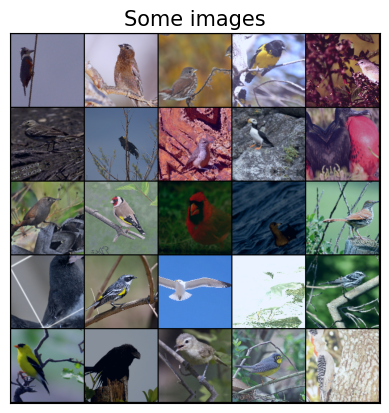

In [8]:
# Let us visualize a few images
images, mask, bbox, labels = next(iter(model_trainer.train_loader))

n_row = 5
out = torchvision.utils.make_grid(images[:n_row**2], nrow=n_row, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.tick_params(axis='both',
                which='both',
                left=False,
                labelleft=False,
                bottom=False,
                labelbottom=False)
plt.title('Some images', fontsize=15)
plt.show()

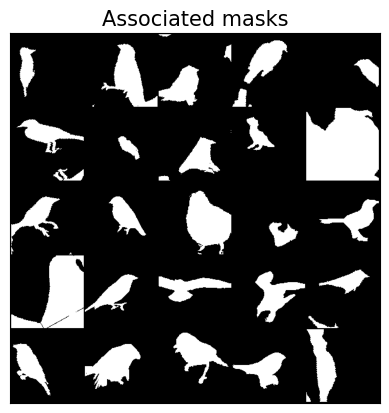

In [9]:
# Associated masks
n_row = 5
out = torchvision.utils.make_grid(mask[:n_row**2].unsqueeze(1).float(), nrow=n_row, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.tick_params(axis='both',
                which='both',
                left=False,
                labelleft=False,
                bottom=False,
                labelbottom=False)
plt.title('Associated masks', fontsize=15)
plt.show()

In [11]:
# Training
start_time = time.time()
model_trainer.run_training(num_epochs=n_epochs)
end_time = time.time()

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

In [12]:
print(f'Highest validation accuracy: {100*model_trainer.best_valid_acc:.2f}%')
print(f'Training time: {(end_time - start_time):.2f} seconds')

Highest validation accuracy: 80.01%
Training time: 13793.79 seconds


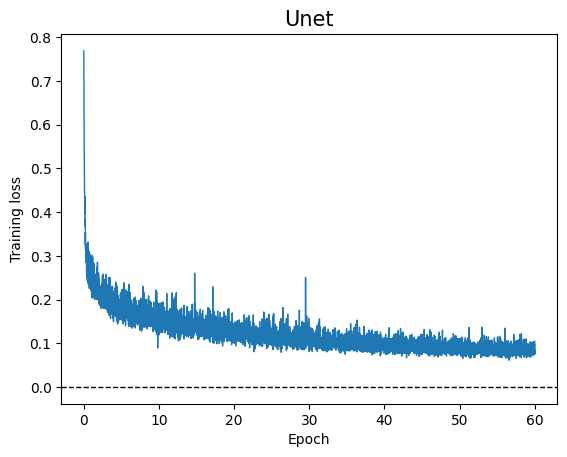

In [13]:
x_epoch = np.linspace(0, n_epochs, len(model_trainer.train_loss_logger))
plt.axhline(y=0, ls='--', color='k', lw=1)
plt.plot(x_epoch, model_trainer.train_loss_logger, lw=1)

xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title(model_name.replace('_', ' '), fontsize=15)
plt.show()

Evaluating Test Set:   0%|          | 0/57 [00:00<?, ?it/s]

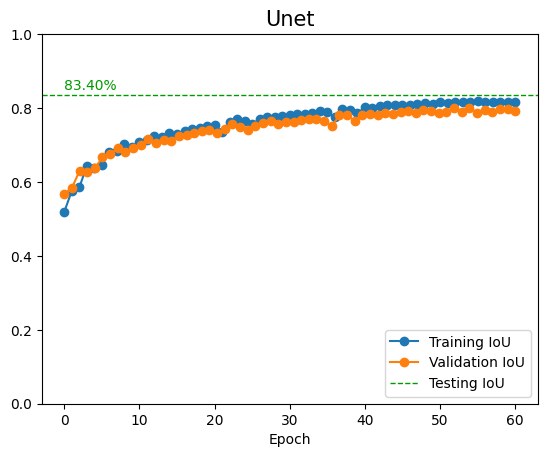

In [15]:
x_epoch = np.linspace(0, n_epochs, len(model_trainer.train_acc_logger))
plt.plot(x_epoch, model_trainer.train_acc_logger, marker='o', label='Training IoU')

x_epoch = np.linspace(0, n_epochs, len(model_trainer.val_acc_logger))
plt.plot(x_epoch, model_trainer.val_acc_logger, marker='o', label='Validation IoU')

testing_accuracy = model_trainer.evaluate_model(train_test_val='test')
plt.axhline(y=testing_accuracy, color=[0, 0.6, 0], ls='--', lw=1, label='Testing IoU')
plt.text(0, 1.01*testing_accuracy, f'{100*testing_accuracy:.2f}%', color=[0, 0.6, 0], va='bottom')

plt.ylim([0, 1])
xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.title(model_name.replace('_', ' '), fontsize=15)
plt.show()

In [16]:
images, mask, bbox, labels = next(iter(model_trainer.test_loader))
model_trainer.eval()
with torch.no_grad():
    pred_out = model_trainer(images.to(device)).argmax(1).cpu()

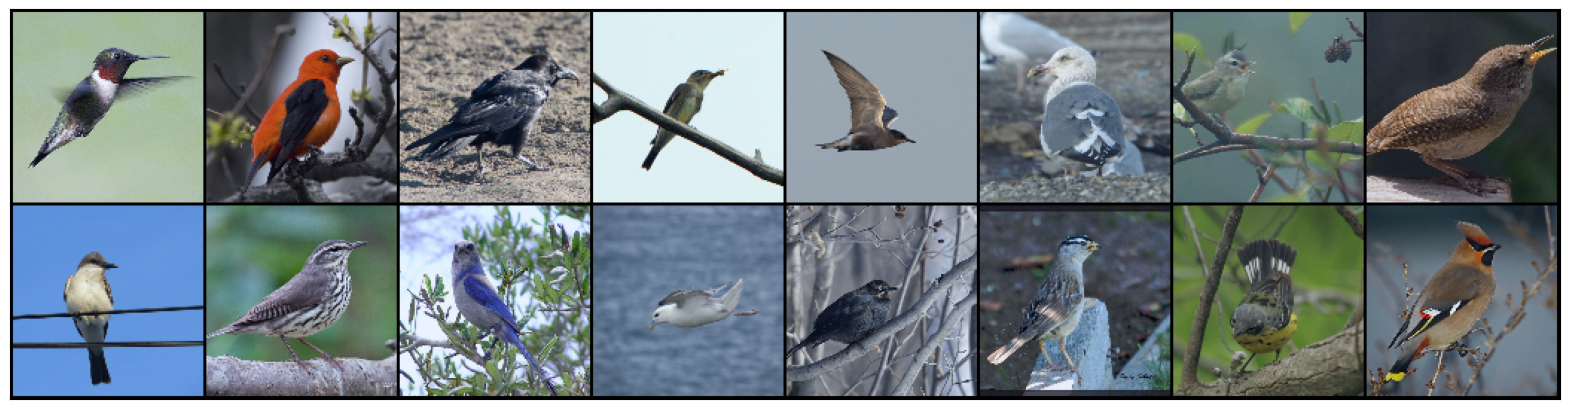

In [18]:
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(images[0:16], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.tick_params(axis='both',
                which='both',
                left=False,
                labelleft=False,
                bottom=False,
                labelbottom=False)
plt.show()

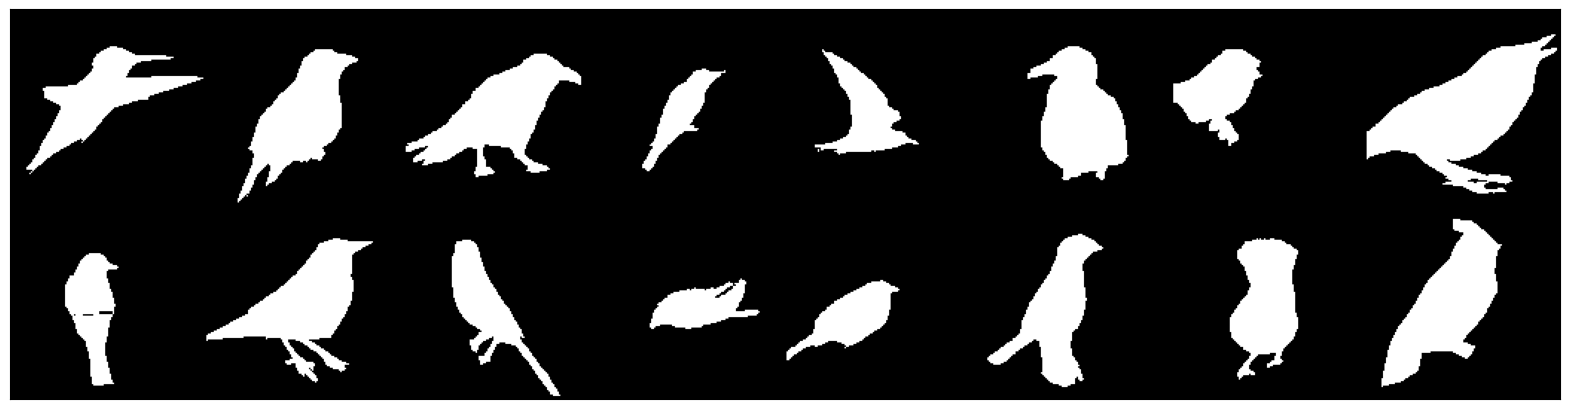

In [19]:
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(mask[0:16].unsqueeze(1).float(), normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.tick_params(axis='both',
                which='both',
                left=False,
                labelleft=False,
                bottom=False,
                labelbottom=False)
plt.show()

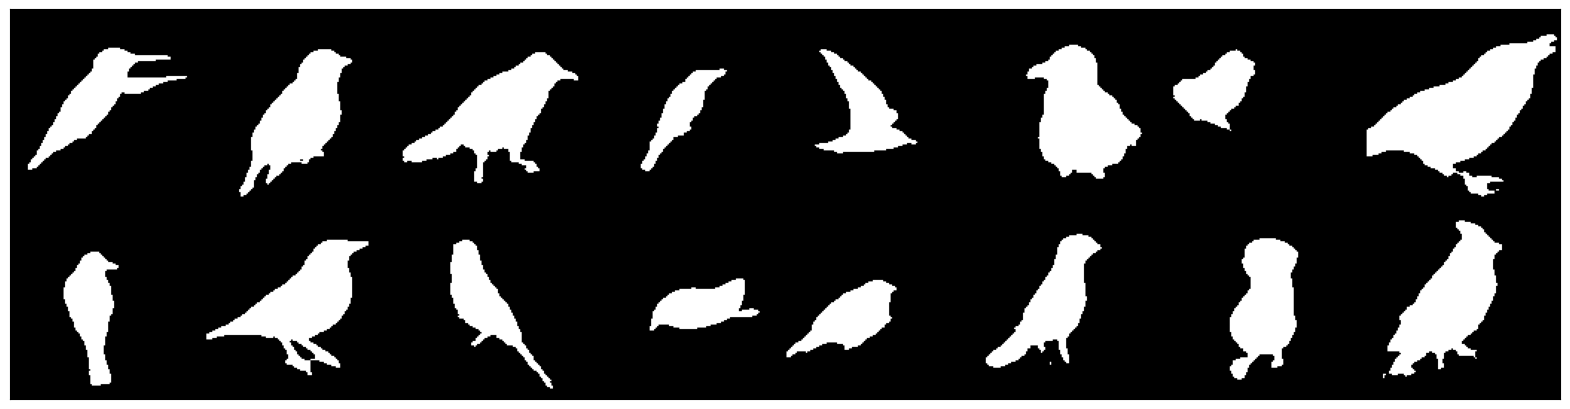

In [20]:
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(pred_out[0:16].unsqueeze(1).float(), normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.tick_params(axis='both',
                which='both',
                left=False,
                labelleft=False,
                bottom=False,
                labelbottom=False)
plt.show()

In [42]:
# Select random test images for the Streamlit web application
all_images = []
all_masks = []
for img, m, _, _ in test_data:
    all_images.append(img)
    all_masks.append(m)

n_images = 500
random_idx = np.random.choice(len(all_images), n_images, replace=False).tolist()
torch.save([all_images[i] for i in random_idx], os.path.join(dataset_path, 'test_images.pt'))
torch.save([all_masks[i] for i in random_idx], os.path.join(dataset_path, 'test_masks.pt'))